In [45]:
%load_ext autoreload
%autoreload 2

import os.path as osp
import jax.random as jr
import pyrootutils
from functools import partial
import matplotlib.pyplot as plt

root = pyrootutils.setup_root(
    search_from=osp.abspath(''),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,  # add to system path 
    dotenv=True,      # load environment variables .env file
    cwd=True,         # change cwd to root
)

import hydra
import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
from qdax.utils.metrics import default_qd_metrics
from src.task.dnaqd import QDSearchDNA
from src.problem.levelgen import SimpleLevelGeneration
from src.evo.qd import MAPElites, CMAOptEmitter
from src.model.dev import NCA, NCA_DNA
from src.nn.ca import IdentityAndSobelFilter, SliceOutput, MaxPoolAlive
from src.nn.dna import DNAContextEncoder, DNAControl, DNAIndependentSampler
from src.analysis.levelgen import plot_generated_levels
from src.utils import tree_shape
from src.analysis.run_utils import select_and_unstack, generate_outputs
from bin.init.config import load_model_weights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = NCA_DNA(
    nca=NCA(
        state_size=16,
        grid_size=(5, 5),
        dev_steps=(30, 40),
        update_prob=0.5,
        context_encoder=DNAContextEncoder(4, 8, 16, key=jr.PRNGKey(5)),
        control_fn=DNAControl(16, 16, 16, key=jr.PRNGKey(4)),
        alive_fn=MaxPoolAlive(alive_bit=3, alive_threshold=0.1),
        message_fn=IdentityAndSobelFilter(),
        update_fn=nn.Sequential(
            layers=[
                nn.Conv2d(in_channels=16 * 3, out_channels=32, kernel_size=1, key=jr.PRNGKey(1)),
                nn.Lambda(jax.nn.relu),
                nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, key=jr.PRNGKey(2)),
            ],
        ),
        output_decoder=SliceOutput(
            dim=0,
            start_idx=0,
            end_idx=3,
            squashing_function=partial(jax.numpy.argmax, axis=0),
        ),
        output_dev_steps=True,
    ),
    dna_generator=DNAIndependentSampler(
        8, 4, jr.PRNGKey(3)
    ),
)

In [3]:
qd_algorithm = MAPElites(
    CMAOptEmitter(
        10,
        32,
        0.1,
        num_descriptors = 2,
        num_centroids = 10,
        random_key= jr.PRNGKey(6),
    ),
    partial(default_qd_metrics, qd_offset=0.0),
)


# jaxpr = jax.make_jaxpr(qd_algorithm.init)
# print(jaxpr.jaxpr)


task = QDSearchDNA(
    SimpleLevelGeneration(5, 5),
    qd_algorithm=qd_algorithm,
    n_iters=2,
    popsize=10,
    n_centroids=10,
    n_centroid_samples=100,
)

In [4]:
model_outputs = generate_outputs(model, task, jr.PRNGKey(0))

/Users/mlle/Repos/grow-ai/dna-guided-ncas/src/evo/qd.py:52: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


## Testing plots

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# from matplotlib.animation import FuncAnimation, PillowWriter
# from IPython.display import HTML

In [9]:
dna_distribution_1 = np.random.randint(0, 4, size=(100, 32))
dna_distribution_2 = np.random.randint(0, 4, size=(100, 32))

scores_1 = np.random.normal(0, 1., size=(100,))
scores_2 = np.random.normal(0.3, 1., size=(100,))

projection = TSNE(2).fit_transform(np.concatenate([dna_distribution_1, dna_distribution_2]))

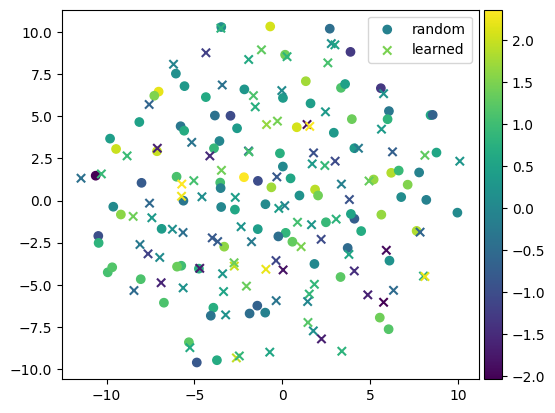

In [16]:
# print(projection.shape)
x, y = projection.T
x_1, x_2 = np.split(x, 2)
y_1, y_2 = np.split(y, 2)

plt.scatter(x_1, y_1, c=scores_1, marker='o', label='random')
im = plt.scatter(x_2, y_2, c=scores_2, marker='x', label='learned')
plt.colorbar(im, pad=0.01)
plt.legend()

## Testing metric aggregation

In [36]:
from itertools import product

def validate_model_outputs(model_outputs, task, key):
    (dnas, outputs, _), _, (scores, metrics), ((repertoire, _, _), _) = model_outputs
    
    fitness, extra_terms = task.overall_fitness((dnas, outputs), metrics, repertoire, key)
    metrics['fitness'] = fitness
    
    bd_bests = scores[1].max(axis=1)
    bd_means = scores[1].mean(axis=1)
    stats = jnp.concatenate([bd_bests, bd_means], axis=1).T
    
    bd_names = task.problem.descriptor_names
    dict_keys = product(("max", "mean"), bd_names)
    
    bd_metrics = {f"{bd}_{stat}": v for ((bd, stat), v) in zip(dict_keys, stats)}
    metrics =  {**metrics, **extra_terms, **bd_metrics}
    
    return metrics

In [37]:
validate_model_outputs(model_outputs, task, jr.key(0))

{'coverage': Array([30., 30.], dtype=float32),
 'max_fitness': Array([24., 24.], dtype=float32),
 'qd_score': Array([48., 48.], dtype=float32),
 'fitness': Array([ 21.200756, 371.0088  ], dtype=float32),
 'aggregated_qd_score': Array([14.4, 14.4], dtype=float32),
 'dna_variance': Array([  6.800756, 356.6088  ], dtype=float32),
 'max_path length': Array([9., 9.], dtype=float32),
 'max_symmetry': Array([10.,  9.], dtype=float32),
 'mean_path length': Array([5.7000003, 8.8      ], dtype=float32),
 'mean_symmetry': Array([6.6      , 5.2000003], dtype=float32)}

## Testing DNA interventions

In [47]:
def intervene_on_dna(model, dna_dist, attn_weights):
    dna = dna_dist.argmax(-1)
    # attn_weights has shape (n_dev_iters, dna_seqlen, H, W)
    max_gene_idx = attn_weights.mean([0, 2, 3]).argmax()
    
    max_gene = dna[max_gene_idx]
    dna = dan.at[max_gene].set(0)  # lets fix this for now
    
    output,